In [1]:
from mssm.models import *
from mssm.src.python.compare import compare_CDL
from mssmViz.sim import *
from mssmViz.plot import *
import numpy as np
import scipy as scp
from matplotlib import pyplot as plt

import sys
import os
import inspect

SCRIPT_DIR = "./../tests"
sys.path.append(os.path.dirname(SCRIPT_DIR))

from tests.defaults import default_gamm_test_kwargs,default_gammlss_test_kwargs,default_gsmm_test_kwargs,default_compare_test_kwargs

size_conv = 2.54
single_width = 6/size_conv
double_width = 12/size_conv
full_width = 19/size_conv

plt.rcParams["font.size"] = 8
plt.rcParams["axes.titlesize"] = 9.5
plt.rcParams["axes.labelsize"] = 8
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["figure.titlesize"] = 11

In [2]:
test_kwargs = copy.deepcopy(default_gamm_test_kwargs)
test_kwargs["progress_bar"] = False
test_kwargs["max_outer"] = 200
test_kwargs["max_inner"] = 500
test_kwargs["extend_lambda"] = False

n_sim = 1000
n_dat = 500

############################################### Univariate Smooth ############################################### 

ps_n = []
ps_bi = []
ps_te = []
ps_bi_te = []

ps_GLRT_n = []
ps_GLRT_bi = []
ps_GLRT_te = []
ps_GLRT_bi_te = []


for simi in tqdm(range(n_sim)):
    sim_dat = sim3(n=n_dat,scale=2,c=0,seed=simi)
    
    formula1 = Formula(lhs("y"),[i(),f(["x0"]),f(["x1"]),f(["x2"]),f(["x3"])],data=sim_dat)
    model1 = GAMM(formula1,Gaussian())
    model1.fit(**test_kwargs)
    formula2 = Formula(lhs("y"),[i(),f(["x1"]),f(["x2"]),f(["x3"])],data=sim_dat)
    model2 = GAMM(formula2,Gaussian())
    model2.fit(**test_kwargs)

    # Compute bunch of p-values
    res = compare_CDL(model1,model2,correct_t1=True,perform_GLRT=True)
    pss, Trs = approx_smooth_p_values(model1)
    ps_GLRT_n.append(res['p'])
    ps_n.append(pss[0])

    # Binomial
    sim_dat = sim3(n=n_dat,scale=2,c=0,seed=simi,family=Binomial(),binom_offset=-5)
    
    formula1 = Formula(lhs("y"),[i(),f(["x0"]),f(["x1"]),f(["x2"]),f(["x3"])],data=sim_dat)
    model1 = GAMM(formula1,Binomial())
    model1.fit(**test_kwargs)
    formula2 = Formula(lhs("y"),[i(),f(["x1"]),f(["x2"]),f(["x3"])],data=sim_dat)
    model2 = GAMM(formula2,Binomial())
    model2.fit(**test_kwargs)

    # Compute bunch of p-values
    res = compare_CDL(model1,model2,correct_t1=True,perform_GLRT=True)
    pss, Trs = approx_smooth_p_values(model1)
    ps_GLRT_bi.append(res['p'])
    ps_bi.append(pss[0])

    ############################################### Tensor Smooth ############################################### 

    sim_dat = sim3(n=n_dat,scale=2,c=0,seed=simi)
    
    formula1 = Formula(lhs("y"),[i(),f(["x0","x3"],te=True,nk=5),f(["x1"]),f(["x2"])],data=sim_dat)
    model1 = GAMM(formula1,Gaussian())
    model1.fit(**test_kwargs)
    formula2 = Formula(lhs("y"),[i(),f(["x1"]),f(["x2"])],data=sim_dat)
    model2 = GAMM(formula2,Gaussian())
    model2.fit(**test_kwargs)

    # Compute bunch of p-values
    res = compare_CDL(model1,model2,correct_t1=True,perform_GLRT=True)
    pss, Trs = approx_smooth_p_values(model1)
    ps_GLRT_te.append(res['p'])
    ps_te.append(pss[0])

    # Binomial
    sim_dat = sim3(n=n_dat,scale=2,c=0,seed=simi,family=Binomial(),binom_offset=-5)
    
    formula1 = Formula(lhs("y"),[i(),f(["x0","x3"],te=True,nk=5),f(["x1"]),f(["x2"])],data=sim_dat)
    model1 = GAMM(formula1,Binomial())
    model1.fit(**test_kwargs)
    formula2 = Formula(lhs("y"),[i(),f(["x1"]),f(["x2"])],data=sim_dat)
    model2 = GAMM(formula2,Binomial())
    model2.fit(**test_kwargs)

    # Compute bunch of p-values
    res = compare_CDL(model1,model2,correct_t1=True,perform_GLRT=True)
    pss, Trs = approx_smooth_p_values(model1)
    ps_GLRT_bi_te.append(res['p'])
    ps_bi_te.append(pss[0])


  9%|▊         | 87/1000 [11:43<1:54:56,  7.55s/it]/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/utils.py:878: UserWarning: Falling back to approximate p-value computation. Error codes: 1, 1
  warnings.warn(f"Falling back to approximate p-value computation. Error codes: {code1}, {code2}")
 18%|█▊        | 180/1000 [24:24<2:00:31,  8.82s/it]/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/utils.py:878: UserWarning: Falling back to approximate p-value computation. Error codes: 1, 1
  warnings.warn(f"Falling back to approximate p-value computation. Error codes: {code1}, {code2}")
 18%|█▊        | 183/1000 [24:50<1:57:20,  8.62s/it]/Users/joshmac/Documents/repos/mssm/src/mssm/src/python/utils.py:878: UserWarning: Falling back to approximate p-value computation. Error codes: 1, 1
  warnings.warn(f"Falling back to approximate p-value computation. Error codes: {code1}, {code2}")
 31%|███       | 311/1000 [42:09<1:35:43,  8.34s/it]/Users/joshmac/Documents/repos/mssm/src/mssm/s

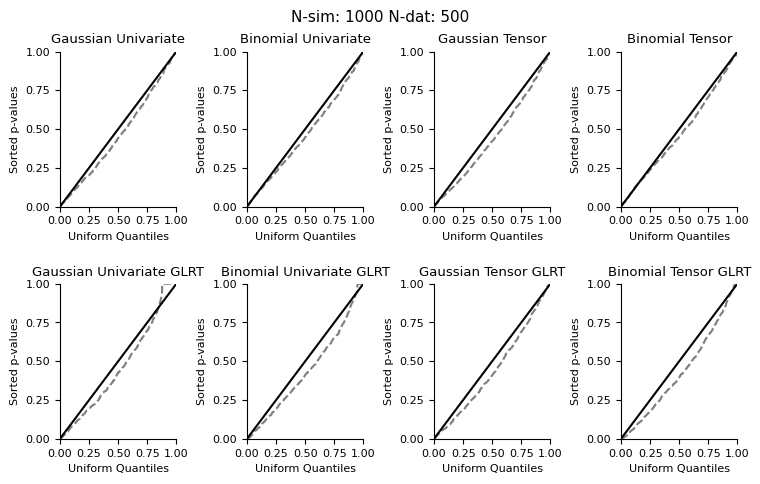

In [3]:
fig = plt.figure(figsize=(full_width,2*single_width),layout='constrained')
axs = fig.subplots(2,4,gridspec_kw=dict(wspace=0.01,hspace=0.1))
axs = axs.flatten()

all_ps = [ps_n,ps_bi,ps_te,ps_bi_te,ps_GLRT_n,ps_GLRT_bi,ps_GLRT_te,ps_GLRT_bi_te]
all_titles = ["Gaussian Univariate", "Binomial Univariate",
              "Gaussian Tensor", "Binomial Tensor",
              "Gaussian Univariate GLRT", "Binomial Univariate GLRT",
              "Gaussian Tensor GLRT", "Binomial Tensor GLRT"]

for axi in range(len(all_ps)):
    ps = all_ps[axi]
    ax = axs[axi]

    ps = np.array(ps)
    ps[np.isnan(ps)] = 1
    qs = np.linspace(5/(len(ps)*10),1 - (5/(len(ps)*10)),len(ps))

    ax.plot(scp.stats.uniform.ppf(qs),np.sort(ps),color="gray",linestyle='dashed')
    ax.plot(qs,qs,color="black")

    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax.set_xticks(np.linspace(0,1,5))
    ax.set_yticks(np.linspace(0,1,5))
    ax.set_ylabel("Sorted p-values")
    ax.set_xlabel("Uniform Quantiles")
    ax.set_title(all_titles[axi])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)

fig.suptitle(f"N-sim: {n_sim} N-dat: {n_dat}")
plt.show()